# Tutorial 2 - Atherosclerosis (Xenium + CODEX)

In [1]:
import os
import torch
import scanpy as sc
import importlib
import numpy as np

In [ ]:
from COSIE.data_preprocessing import load_data
from COSIE.utils import setup_seed
from COSIE.configure import get_default_config
from COSIE.COSIE_framework import COSIE_model
from COSIE.downstream_analysis import *

config = get_default_config()
setup_seed(config['training']['seed'])


## Load data

(1) section1: HE + Xenium_panel1

(2) section2: HE + Xenium_panel2

(3) section3: HE + CODEX

In [3]:
file_path = '../../../project/SpatialMultimodal/datasets/Atherosclerosis'

In [4]:
adata_panel1 = sc.read_h5ad(os.path.join(file_path,'adata_Xenium_panel1.h5ad'))
adata_panel2 = sc.read_h5ad(os.path.join(file_path,'adata_Xenium_panel2.h5ad'))
adata_codex = sc.read_h5ad(os.path.join(file_path,'adata_CODEX.h5ad'))
adata_panel1, adata_panel2, adata_codex

(AnnData object with n_obs × n_vars = 432290 × 314
     obsm: 'UNI_feature', 'spatial', 'transformed_pxl_loc_in_morphology',
 AnnData object with n_obs × n_vars = 412152 × 345
     obsm: 'UNI_feature', 'spatial', 'transformed_pxl_loc_in_morphology',
 AnnData object with n_obs × n_vars = 430530 × 43
     obsm: 'UNI_feature', 'spatial', 'transformed_pxl_loc_in_dapi')

In [5]:
adata_panel1.var_names_make_unique()
adata_panel2.var_names_make_unique()
adata_codex.var_names_make_unique()

In [6]:
adata1_he = sc.AnnData(X=adata_panel1.obsm['UNI_feature'])
adata1_he.obsm['spatial'] = adata_panel1.obsm['spatial'].copy()
adata2_he = sc.AnnData(X=adata_panel2.obsm['UNI_feature'])
adata2_he.obsm['spatial'] = adata_panel2.obsm['spatial'].copy()

adata1_he, adata2_he

(AnnData object with n_obs × n_vars = 432290 × 2048
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 412152 × 2048
     obsm: 'spatial')

In [7]:
adata3_he = sc.AnnData(X=adata_codex.obsm['UNI_feature'])
adata3_he.obsm['spatial'] = adata_codex.obsm['spatial'].copy()
adata3_he

AnnData object with n_obs × n_vars = 430530 × 2048
    obsm: 'spatial'

## Define the dictionary structure for input data

Each column denotes one section and None represents that the modality is missing in that section.

In [8]:
data_dict = {
        'HE': [adata1_he, adata2_he, adata3_he],
        'RNA': [adata_panel1, None, None],
        'RNA_panel2': [None, adata_panel2, None],
        'Protein': [None, None, adata_codex]
    }

## Specify the linkage indicator

COSIE requires a indicator dictionary to specify the cross-section linkage used during training. COSIE utilized all the available strong and weak linkages during integration.

In [9]:
Linkage_indicator = {
        ('s1', 's2'): [('HE', 'HE'), ('RNA', 'RNA_panel2')],
        ('s1', 's3'): [('HE','HE'),('RNA', 'Protein')],
        ('s2', 's3'): [('HE','HE'),('RNA_panel2', 'Protein')],
    }

In [10]:
feature_dict, spatial_loc_dict, data_dict_processed = load_data(data_dict, hvg_num=None, n_comps=50, metacell = True)

Combine adjacent 4 cells into metacell to save memory and speed up computation
-------- Processing shared modality HE across sections --------
Running Harmony for HE


2025-05-17 20:32:56,821 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-17 20:33:13,212 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-17 20:33:15,253 - harmonypy - INFO - Iteration 1 of 10
2025-05-17 20:34:54,525 - harmonypy - INFO - Iteration 2 of 10
2025-05-17 20:36:41,663 - harmonypy - INFO - Converged after 2 iterations


-------- Processing unique modality RNA for section 1 --------
-------- Processing unique modality RNA_panel2 for section 2 --------
-------- Processing unique modality Protein for section 3 --------
Extracting spatial location for section 1
Extracting spatial location for section 2
Extracting spatial location for section 3


## Define COSIE Model and Perform Integration

After training, embeddings will be saved to `file_path` in `.npy` format.

In [12]:
model = COSIE_model(config, feature_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['lr'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

All modalities: ['HE', 'RNA', 'RNA_panel2', 'Protein']
-------- Encoder description --------
Encoder [HE]: Input 50 → Hidden [256, 128]
Encoder [RNA]: Input 50 → Hidden [256, 128]
Encoder [RNA_panel2]: Input 50 → Hidden [256, 128]
Encoder [Protein]: Input 20 → Hidden [256, 128]
-------- Dual prediction module description --------
Predictor [HE → RNA]: [128, 512, 512, 128]
Predictor [RNA → HE]: [128, 512, 512, 128]
Predictor [HE → RNA_panel2]: [128, 512, 512, 128]
Predictor [RNA_panel2 → HE]: [128, 512, 512, 128]
Predictor [HE → Protein]: [128, 512, 512, 128]
Predictor [Protein → HE]: [128, 512, 512, 128]
Using device: cuda:0


In [13]:
final_embeddings = model.train_model(file_path, config, optimizer, device, feature_dict, spatial_loc_dict, 
                                     data_dict_processed, Linkage_indicator, n_x=1, n_y=2)

-------- Running Sub-graph training mode, n_x is 1, n_y is 2 --------
Splitting section [s1] into 1 x 2 subgraphs
Splitting HE in section s1...
Splitting RNA in section s1...
Splitting section [s2] into 1 x 2 subgraphs
Splitting HE in section s2...
Splitting RNA_panel2 in section s2...
Splitting section [s3] into 1 x 2 subgraphs
Splitting HE in section s3...
Splitting Protein in section s3...
Computing linkage between [HE] (s1-0) and [HE] (s2-0)
Computing linkage between [RNA] (s1-0) and [RNA_panel2] (s2-0)
Number of overlapping features: 111
Computing linkage between [HE] (s1-0) and [HE] (s2-1)
Computing linkage between [RNA] (s1-0) and [RNA_panel2] (s2-1)
Number of overlapping features: 111
Computing linkage between [HE] (s1-1) and [HE] (s2-0)
Computing linkage between [RNA] (s1-1) and [RNA_panel2] (s2-0)
Number of overlapping features: 111
Computing linkage between [HE] (s1-1) and [HE] (s2-1)
Computing linkage between [RNA] (s1-1) and [RNA_panel2] (s2-1)
Number of overlapping featur

Training Epochs: 100%|████████████████████████████████████████████████████████████████| 600/600 [12:10<00:00,  1.22s/it]


 Running Evaluation...
Missing modality [RNA_panel2] in Section [s1]
Using predictor [HE → RNA_panel2] to recover missing embedding...
Missing modality [Protein] in Section [s1]
Using predictor [HE → Protein] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s1 using modality [HE]
Missing modality [RNA] in Section [s2]
Using predictor [HE → RNA] to recover missing embedding...
Missing modality [Protein] in Section [s2]
Using predictor [HE → Protein] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s2 using modality [HE]
Missing modality [RNA] in Section [s3]
Using predictor [HE → RNA] to recover missing embedding...
Missing modality [RNA_panel2] in Section [s3]
Using predictor [HE → RNA_panel2] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s3 using modality [HE]
All embeddings have been saved to ../../../project/SpatialMultimodal/datasets/Atherosclero

## Perform clustering and visualization

Perform joint clustering...


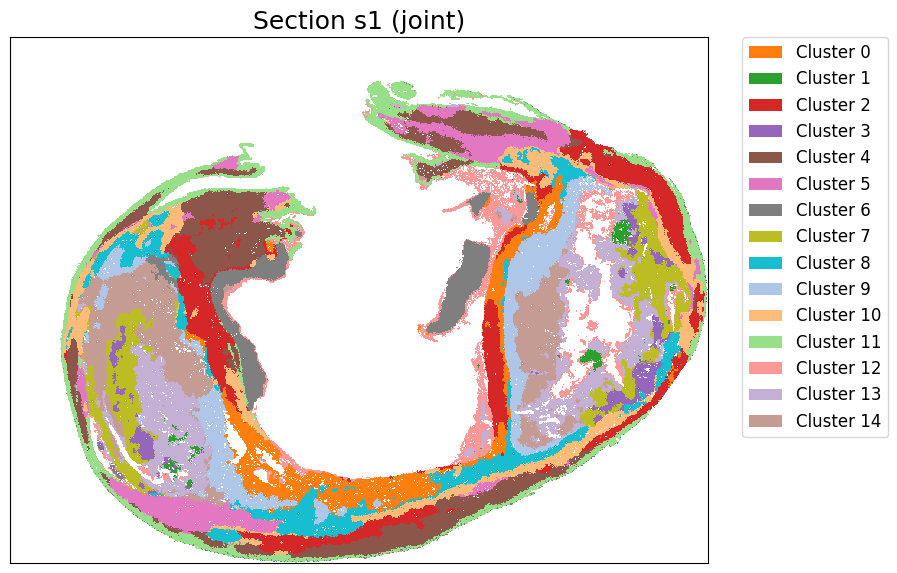

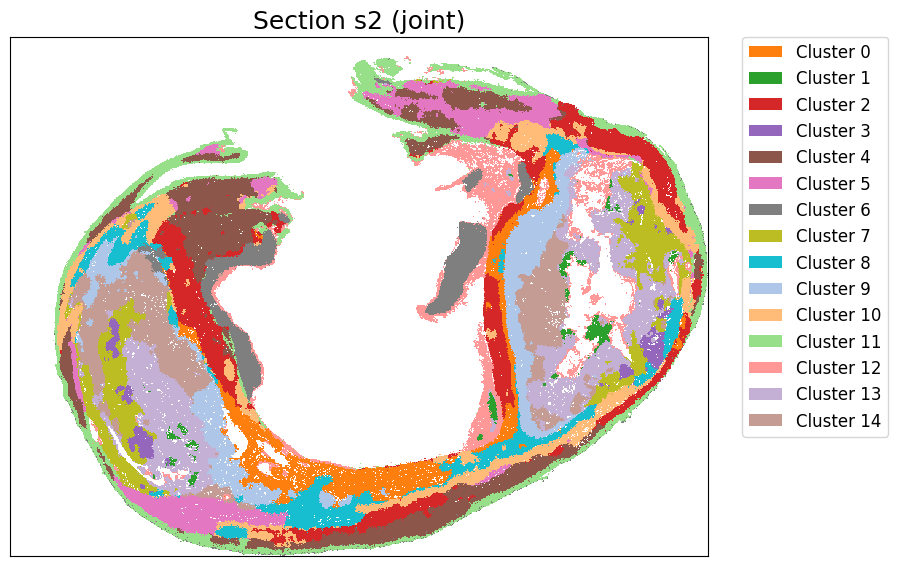

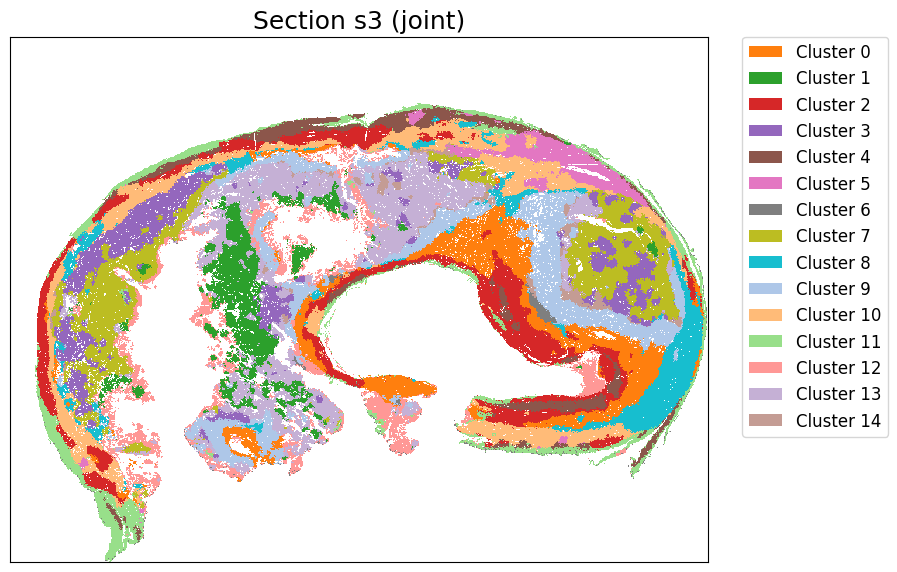

In [19]:
cluster_label = cluster_and_visualize_superpixel(final_embeddings, 
                                                 data_dict,
                                                 n_clusters=15,
                                                 mode="joint", 
                                                 vis_basis="spatial",  
                                                 figscale = 120)

## Perform prediction

For prediction convenience, separate panel1-specific genes, panel2-specific genes and common genes

In [20]:
common_genes = adata_panel1.var_names.intersection(adata_panel2.var_names)
len(common_genes)

111

In [21]:
adata_panel1_com = adata_panel1[:, common_genes].copy()
adata_panel2_com = adata_panel2[:, common_genes].copy()
adata_panel1_com.obs_names = adata_panel1_com.obs_names + "_p1"
adata_panel2_com.obs_names = adata_panel2_com.obs_names + "_p2"
adata_panel1_com, adata_panel2_com

(AnnData object with n_obs × n_vars = 432290 × 111
     obsm: 'UNI_feature', 'spatial', 'transformed_pxl_loc_in_morphology',
 AnnData object with n_obs × n_vars = 412152 × 111
     obsm: 'UNI_feature', 'spatial', 'transformed_pxl_loc_in_morphology')

In [22]:
p1_spec_genes = adata_panel1.var_names.difference(common_genes)
p2_spec_genes = adata_panel2.var_names.difference(common_genes)

len(p1_spec_genes), len(p2_spec_genes)

(203, 234)

In [23]:
adata_panel1_spec = adata_panel1[:, p1_spec_genes].copy()
adata_panel2_spec = adata_panel2[:, p2_spec_genes].copy()
adata_panel1_spec, adata_panel2_spec

(AnnData object with n_obs × n_vars = 432290 × 203
     obsm: 'UNI_feature', 'spatial', 'transformed_pxl_loc_in_morphology',
 AnnData object with n_obs × n_vars = 412152 × 234
     obsm: 'UNI_feature', 'spatial', 'transformed_pxl_loc_in_morphology')

In [24]:
data_dict_new = {
        'HE': [adata1_he, adata2_he, adata3_he],
        'RNA_p1_spec': [adata_panel1_spec, None, None],
        'RNA_p2_spec': [None, adata_panel2_spec, None],
        'RNA_com': [adata_panel1_com, adata_panel2_com, None],
        'Protein': [None, None, adata_codex]
    }

#### 1. Prediction of Section1

##### 1-1 Common genes enhancement

In [25]:
adata1_com_predicted = perform_prediction(data_dict_new,
    final_embeddings,
    target_section = 's1',
    target_modality = 'RNA_com',
    source_sections=['s2'],
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s1] as spatial/obs reference
Manually specify ['s2'] as source data


In [26]:
adata1_com_predicted

AnnData object with n_obs × n_vars = 432290 × 111
    obsm: 'spatial'

In [27]:
adata_panel1_norm = create_normalized_adata(adata_panel1)
adata_panel2_norm = create_normalized_adata(adata_panel2)

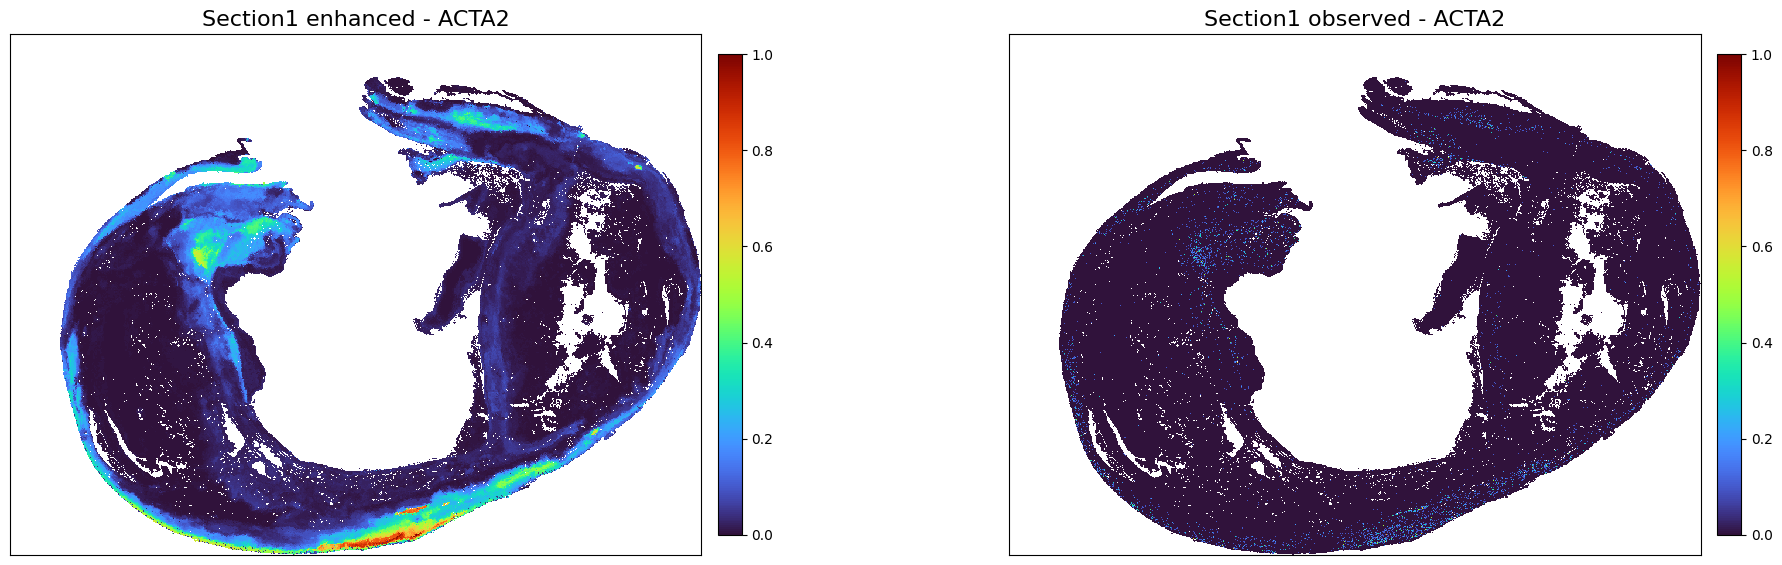

In [29]:
adata1_com_predicted_norm = create_normalized_adata(adata1_com_predicted)
plot_marker_comparison_superpixel('ACTA2', 
                       adata1_com_predicted_norm, 
                       adata_panel1_norm, 
                       'Section1 enhanced', 
                       'Section1 observed',
                        colormap = 'turbo',
                        figscale = 100,)

##### 1-2 Panel2-specific genes prediction

In [30]:
adata1_p2_spec_predicted = perform_prediction(data_dict_new,
    final_embeddings,
    target_section = 's1',
    target_modality = 'RNA_p2_spec',
    source_sections=['s2'],
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s1] as spatial/obs reference
Manually specify ['s2'] as source data


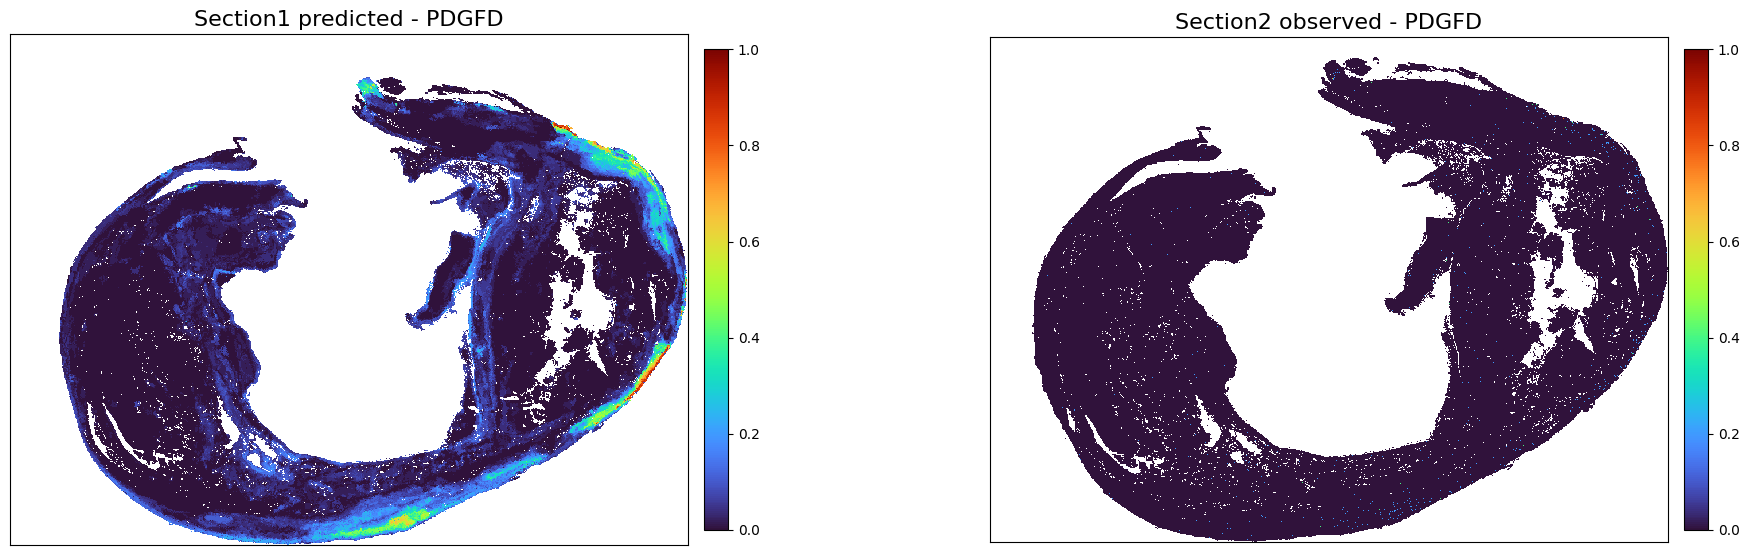

In [31]:
adata1_p2_spec_predicted_norm = create_normalized_adata(adata1_p2_spec_predicted)
plot_marker_comparison_superpixel('PDGFD', 
                       adata1_p2_spec_predicted_norm, 
                       adata_panel2_norm, 
                       'Section1 predicted', 
                       'Section2 observed',
                        colormap = 'turbo',
                        figscale = 100,)

##### 1-3 Protein prediction

In [33]:
adata1_protein_predicted = perform_prediction(data_dict_new,
    final_embeddings,
    target_section = 's1',
    target_modality = 'Protein',
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s1] as spatial/obs reference
[Protein] exists in ['s3'], which will be used as source data section


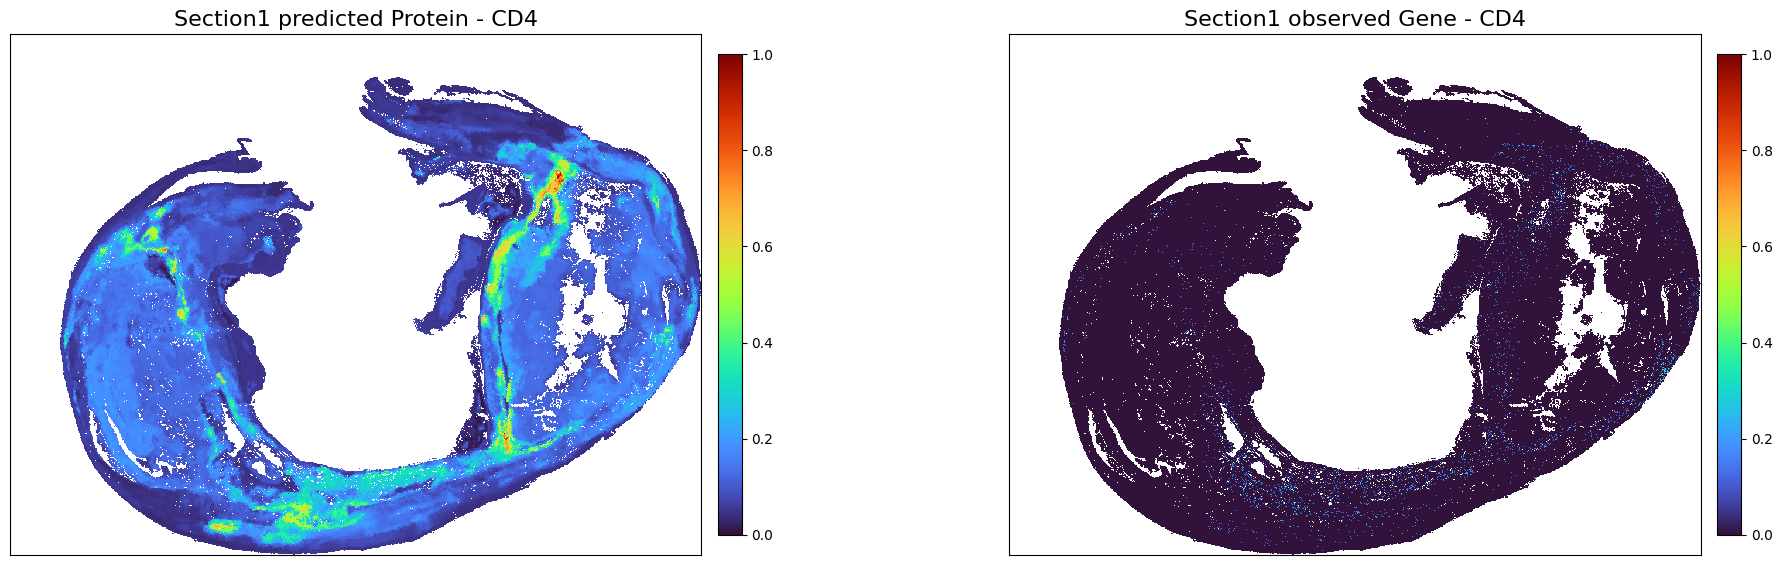

In [34]:
adata1_protein_predicted_norm = create_normalized_adata(adata1_protein_predicted)
plot_marker_comparison_superpixel('CD4', 
                       adata1_protein_predicted_norm, 
                       adata_panel1_norm, 
                       'Section1 predicted Protein', 
                       'Section1 observed Gene',
                        colormap = 'turbo',
                        figscale = 100,)

#### Prediction of Section2

##### 2-1 Common genes enhancement

In [36]:
adata2_com_predicted = perform_prediction(data_dict_new,
    final_embeddings,
    target_section = 's2',
    target_modality = 'RNA_com',
    source_sections=['s1'],
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s2] as spatial/obs reference
Manually specify ['s1'] as source data


In [37]:
adata2_com_predicted

AnnData object with n_obs × n_vars = 412152 × 111
    obsm: 'spatial'

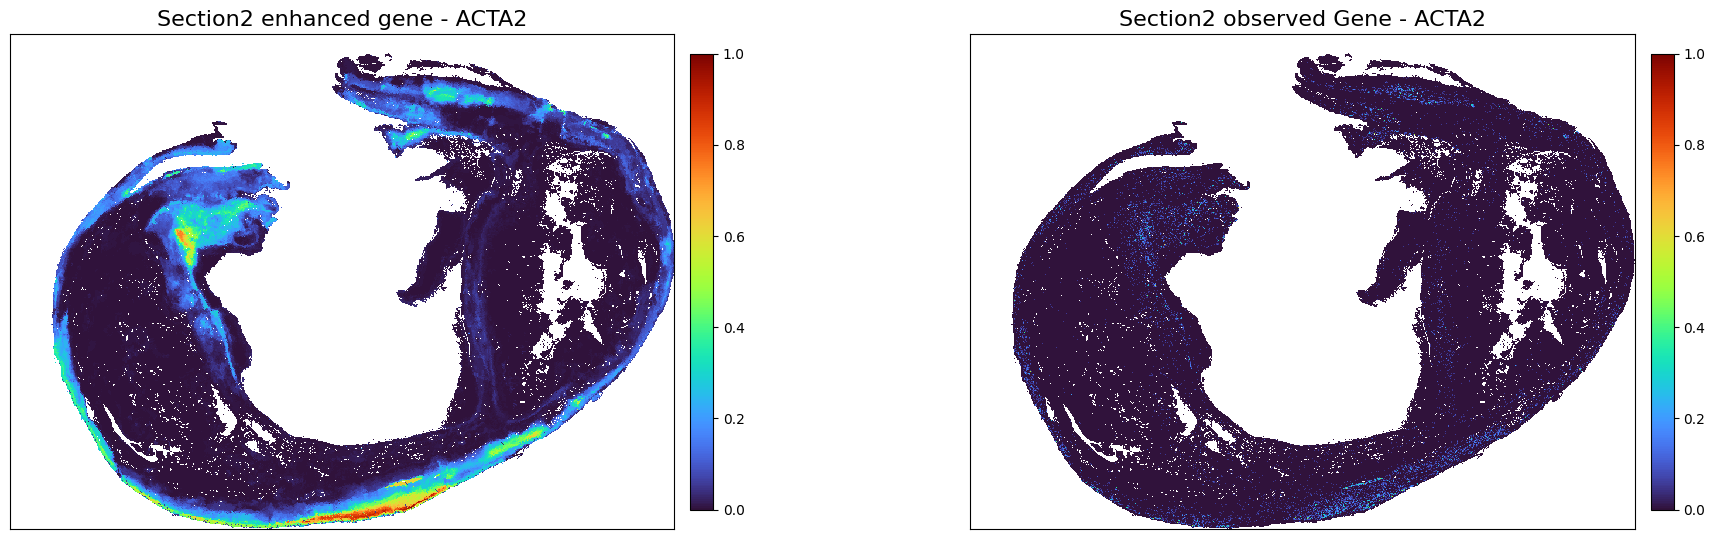

In [38]:
adata2_com_predicted_norm = create_normalized_adata(adata2_com_predicted)
plot_marker_comparison_superpixel('ACTA2', 
                       adata2_com_predicted_norm, 
                       adata_panel2_norm, 
                       'Section2 enhanced gene', 
                       'Section2 observed Gene',
                        colormap = 'turbo',
                        figscale = 100,)


##### 2-2 Panel1-specific genes prediction

In [40]:
adata2_p1_spec_predicted = perform_prediction(data_dict_new,
    final_embeddings,
    target_section = 's2',
    target_modality = 'RNA_p1_spec',
    source_sections=['s1'],
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s2] as spatial/obs reference
Manually specify ['s1'] as source data


In [41]:
adata2_p1_spec_predicted

AnnData object with n_obs × n_vars = 412152 × 203
    obsm: 'spatial'

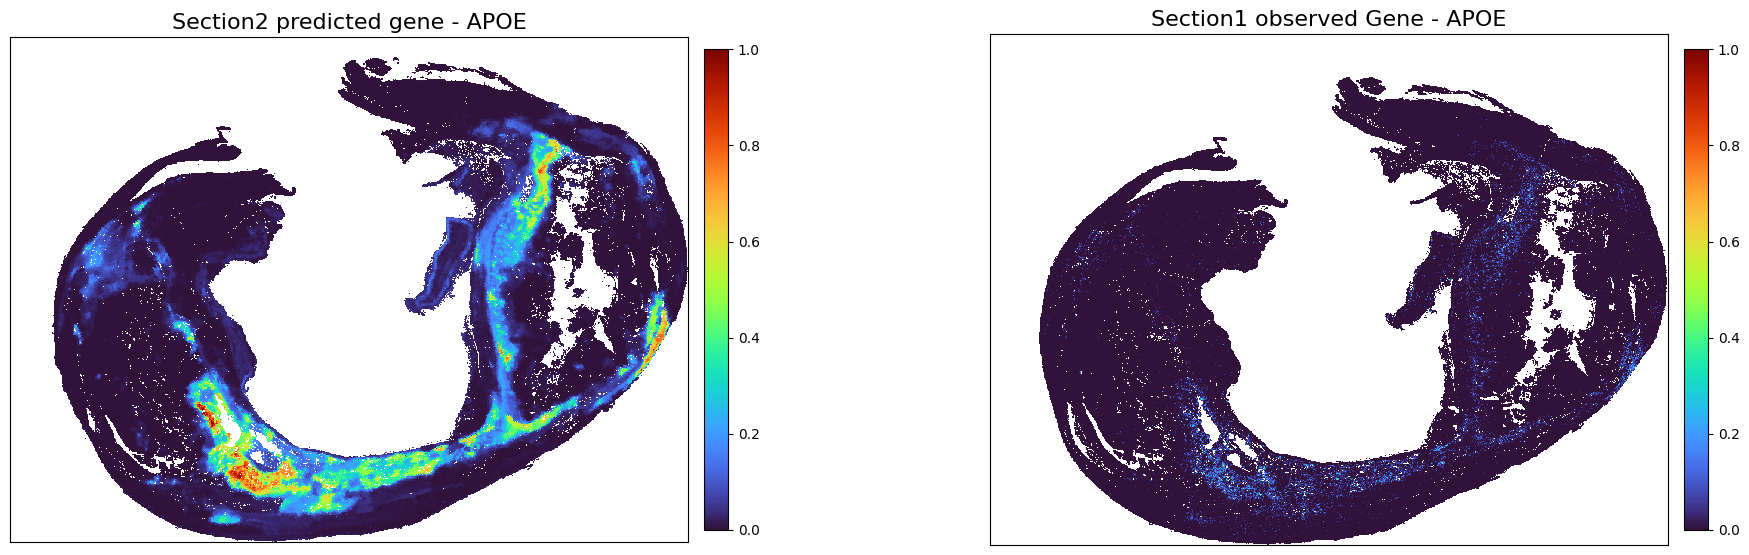

In [43]:
plot_marker_comparison_superpixel('APOE', 
                       adata2_p1_spec_predicted_norm, 
                       adata_panel1_norm, 
                       'Section2 predicted gene', 
                       'Section1 observed Gene',
                        colormap = 'turbo',
                        figscale = 100,)


##### 2-3 Protein prediction

In [44]:
adata2_protein_predicted = perform_prediction(data_dict_new,
    final_embeddings,
    target_section = 's2',
    target_modality = 'Protein',
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s2] as spatial/obs reference
[Protein] exists in ['s3'], which will be used as source data section


In [45]:
adata2_protein_predicted

AnnData object with n_obs × n_vars = 412152 × 43
    obsm: 'spatial'

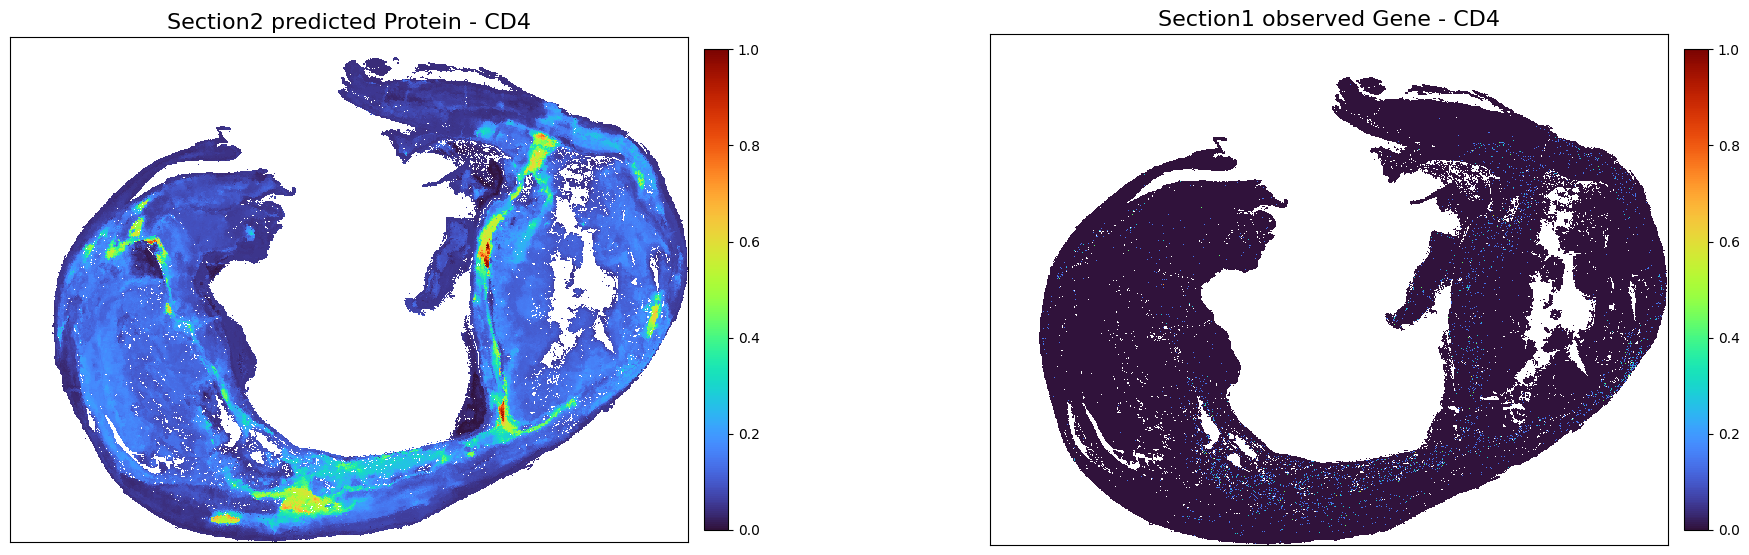

In [46]:
adata2_protein_predicted_norm = create_normalized_adata(adata2_protein_predicted)
plot_marker_comparison_superpixel('CD4', 
                       adata2_protein_predicted_norm, 
                       adata_panel1_norm, 
                       'Section2 predicted Protein', 
                       'Section1 observed Gene',
                        colormap = 'turbo',
                        figscale = 100,)

#### Prediction of Section3

##### 3-1 Common genes prediction

In [48]:
adata3_com_predicted = perform_prediction(data_dict_new,
    final_embeddings,
    target_section = 's3',
    target_modality = 'RNA_com',
    source_sections=['s1','s2'],
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s3] as spatial/obs reference
Manually specify ['s1', 's2'] as source data


In [49]:
adata3_com_predicted

AnnData object with n_obs × n_vars = 430530 × 111
    obsm: 'spatial'

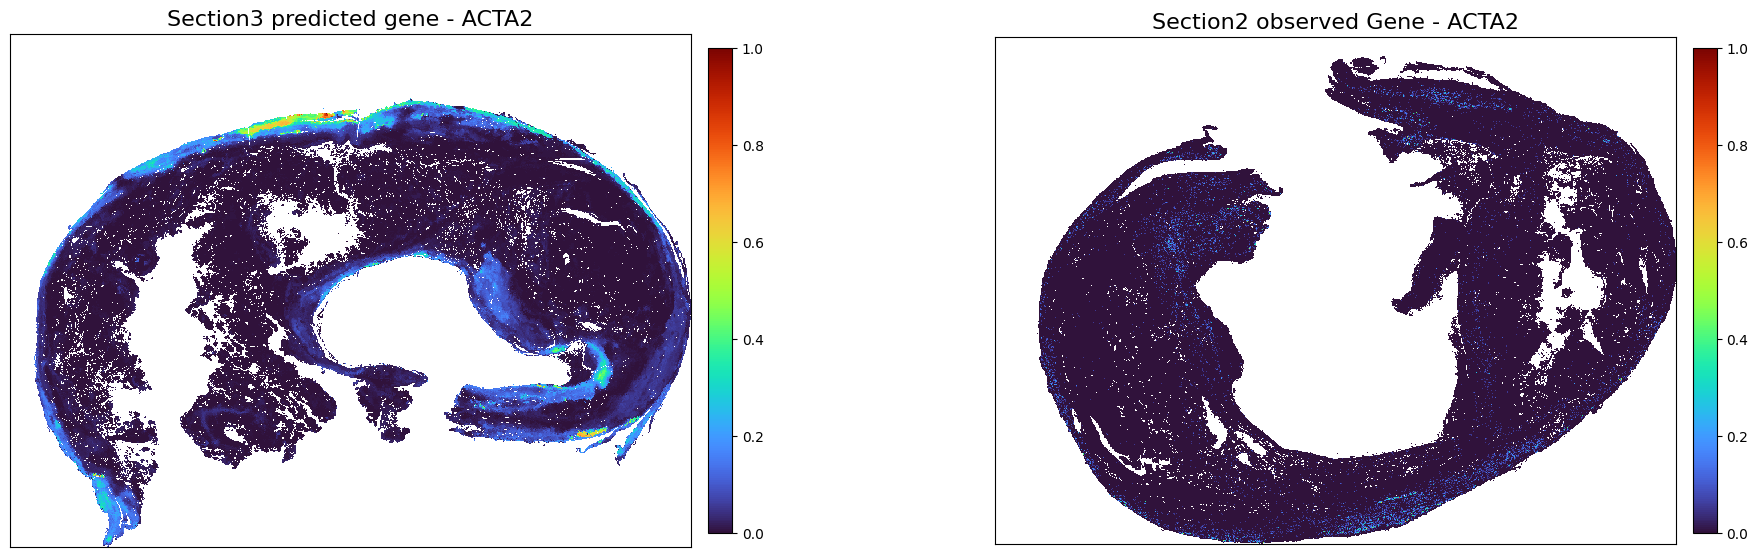

In [50]:
adata3_com_predicted_norm = create_normalized_adata(adata3_com_predicted)
plot_marker_comparison_superpixel('ACTA2', 
                       adata3_com_predicted_norm, 
                       adata_panel2_norm, 
                       'Section3 predicted gene', 
                       'Section2 observed Gene',
                        colormap = 'turbo',
                        figscale = 100,)


##### 3-2 Panel1-specific genes prediction

In [52]:
adata3_p1_spec_predicted = perform_prediction(data_dict_new,
    final_embeddings,
    target_section = 's3',
    target_modality = 'RNA_p1_spec',
    source_sections=['s1'],
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s3] as spatial/obs reference
Manually specify ['s1'] as source data


In [53]:
adata3_p1_spec_predicted

AnnData object with n_obs × n_vars = 430530 × 203
    obsm: 'spatial'

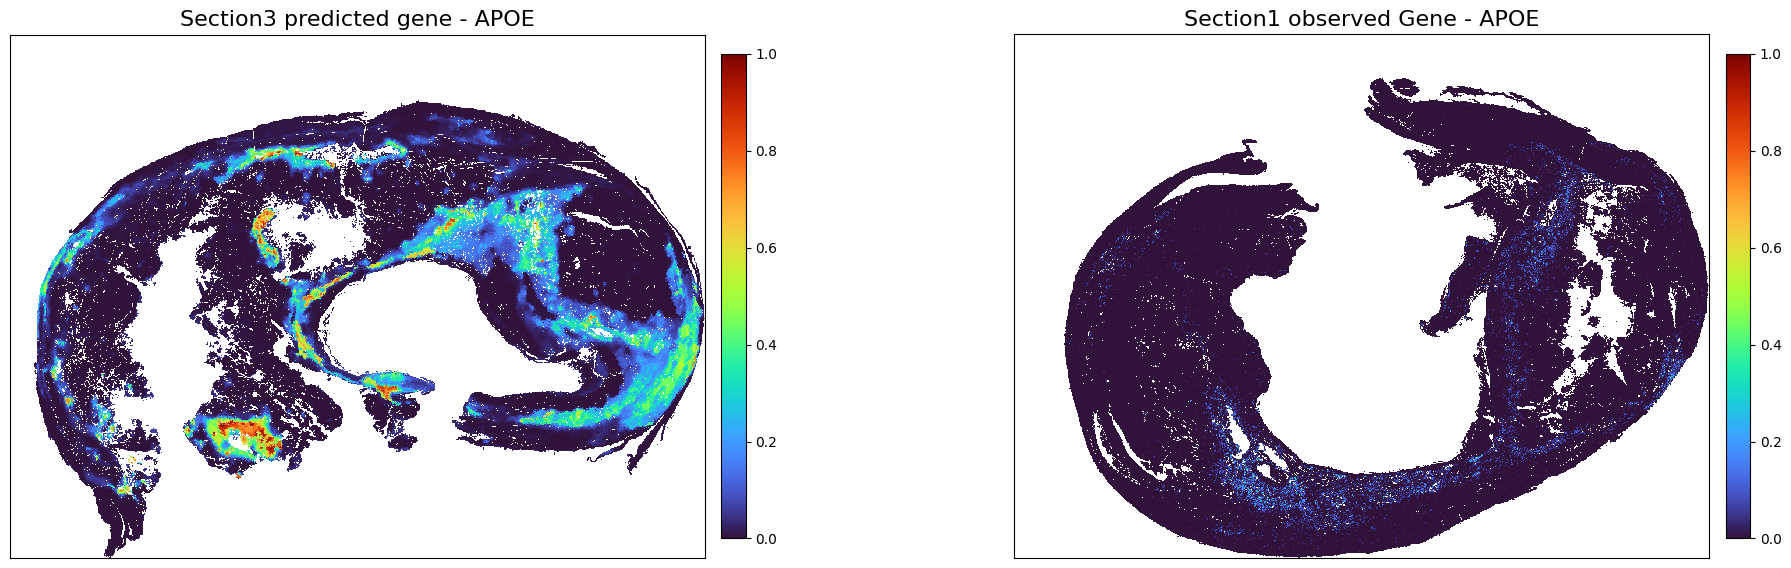

In [54]:
adata3_p1_spec_predicted_norm = create_normalized_adata(adata3_p1_spec_predicted)
plot_marker_comparison_superpixel('APOE', 
                       adata3_p1_spec_predicted_norm, 
                       adata_panel1_norm, 
                       'Section3 predicted gene', 
                       'Section1 observed Gene',
                        colormap = 'turbo',
                        figscale = 100,)


##### 3-3 Panel2-specific genes prediction

In [56]:
adata3_p2_spec_predicted = perform_prediction(data_dict_new,
    final_embeddings,
    target_section = 's3',
    target_modality = 'RNA_p2_spec',
    source_sections=['s2'],
    K_num=500,
    target_molecules='All',
    )

Using modality [HE] in section [s3] as spatial/obs reference
Manually specify ['s2'] as source data


In [57]:
adata3_p2_spec_predicted

AnnData object with n_obs × n_vars = 430530 × 234
    obsm: 'spatial'

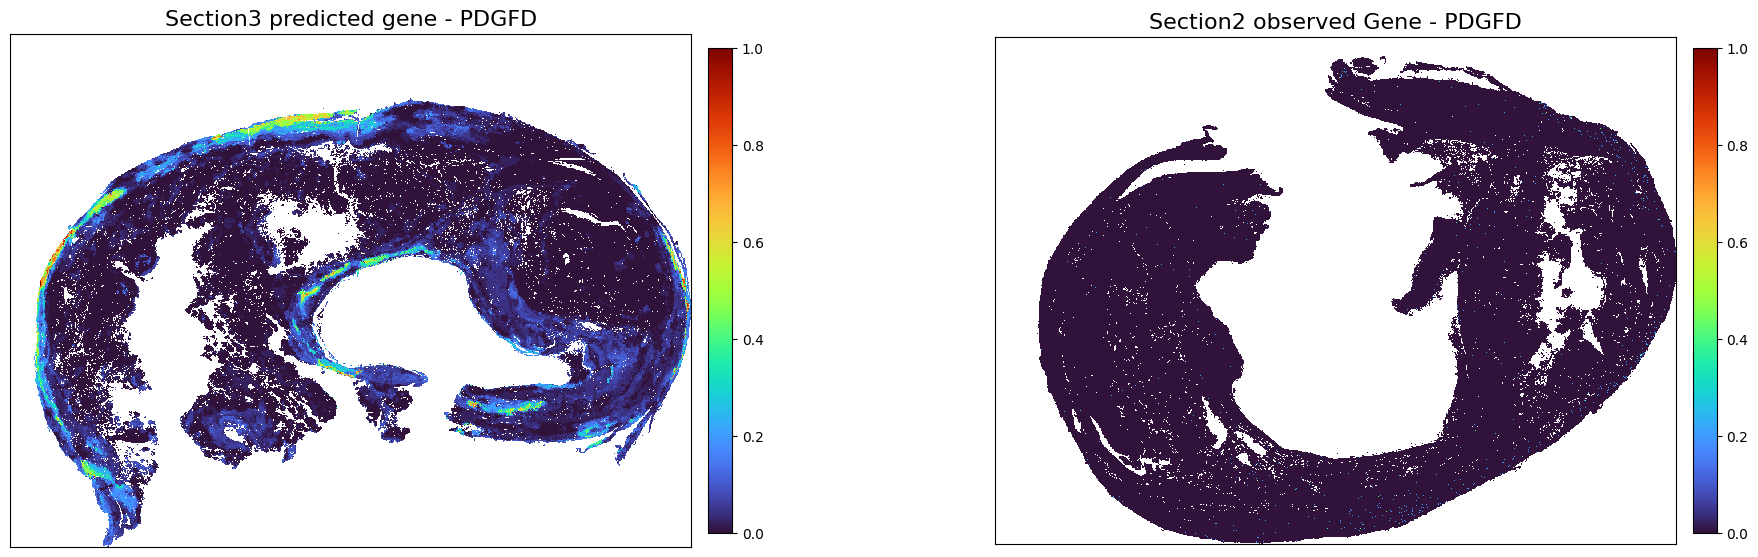

In [58]:
adata3_p2_spec_predicted_norm = create_normalized_adata(adata3_p2_spec_predicted)
plot_marker_comparison_superpixel('PDGFD', 
                       adata3_p2_spec_predicted_norm, 
                       adata_panel2_norm, 
                       'Section3 predicted gene', 
                       'Section2 observed Gene',
                        colormap = 'turbo',
                        figscale = 100,)
